In [1]:
import glob, tqdm, time, os

# Custom tools
import sys
sys.path.append("../../")
import tools

from base import NSM
from base import create_dataset

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scanpy as sc
import scvi
import seaborn as sns
import tqdm
from scipy.stats import linregress

from matplotlib import rcParams
import pyro

from torch.utils.tensorboard import SummaryWriter

Global seed set to 0


In [2]:
DATADIR = "../../data/music/"
SC_FILE = DATADIR + "sc.tsv"
BULK_FILE = DATADIR + "bulk.tsv"

sc.settings.set_figure_params(dpi=60, facecolor='white', figsize=(8,8))

In [3]:
adata = sc.read_csv(SC_FILE, delimiter="\t", first_column_names=True)

# preprocessing and QC
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

andf = pd.read_csv(DATADIR + "pdata.tsv", sep="\t", index_col=0)
andf.index.name = None
# sc.pp.filter_genes(adata, min_counts=1000)
adata.obs = pd.concat([adata.obs, andf], axis=1)
adata.obs

,n_genes,sampleID,SubjectName,cellTypeID,cellType
AZ_A10,5344,1,Non T2D 1,5,delta
AZ_A11,3900,1,Non T2D 1,2,alpha
AZ_A12,2855,1,Non T2D 1,5,delta
AZ_A2,3608,1,Non T2D 1,9,gamma
AZ_A5,2443,1,Non T2D 1,6,ductal
...,...,...,...,...,...
HP1509101_P23,7306,8,Non T2D 6,13,PSC
HP1509101_P4,5929,8,Non T2D 6,2,alpha
HP1509101_P7,6569,8,Non T2D 6,4,co-expression
HP1509101_P8,10106,8,Non T2D 6,6,ductal


In [4]:
bulk_adata = sc.read_csv(BULK_FILE, delimiter="\t")
bulk_adata

AnnData object with n_obs × n_vars = 89 × 32581

In [5]:
common_genes = list(set(bulk_adata.var.index.values).intersection(set(adata.var.index.values)))
bulk_adata = bulk_adata[:,common_genes].copy()
adata = adata[:,common_genes].copy()
print(f"Common genes: {len(common_genes)}")

Common genes: 17526


In [8]:
bulk_adata.obs.index[0]

'Sub1'

In [7]:
# sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True, flavor="seurat_v3")
adata.layers["counts"] = adata.X.copy()
bulk_adata.layers["counts"] = bulk_adata.X.copy()

In [8]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.normalize_total(bulk_adata)
sc.pp.log1p(bulk_adata)

In [9]:
plt.style.use("ggplot")

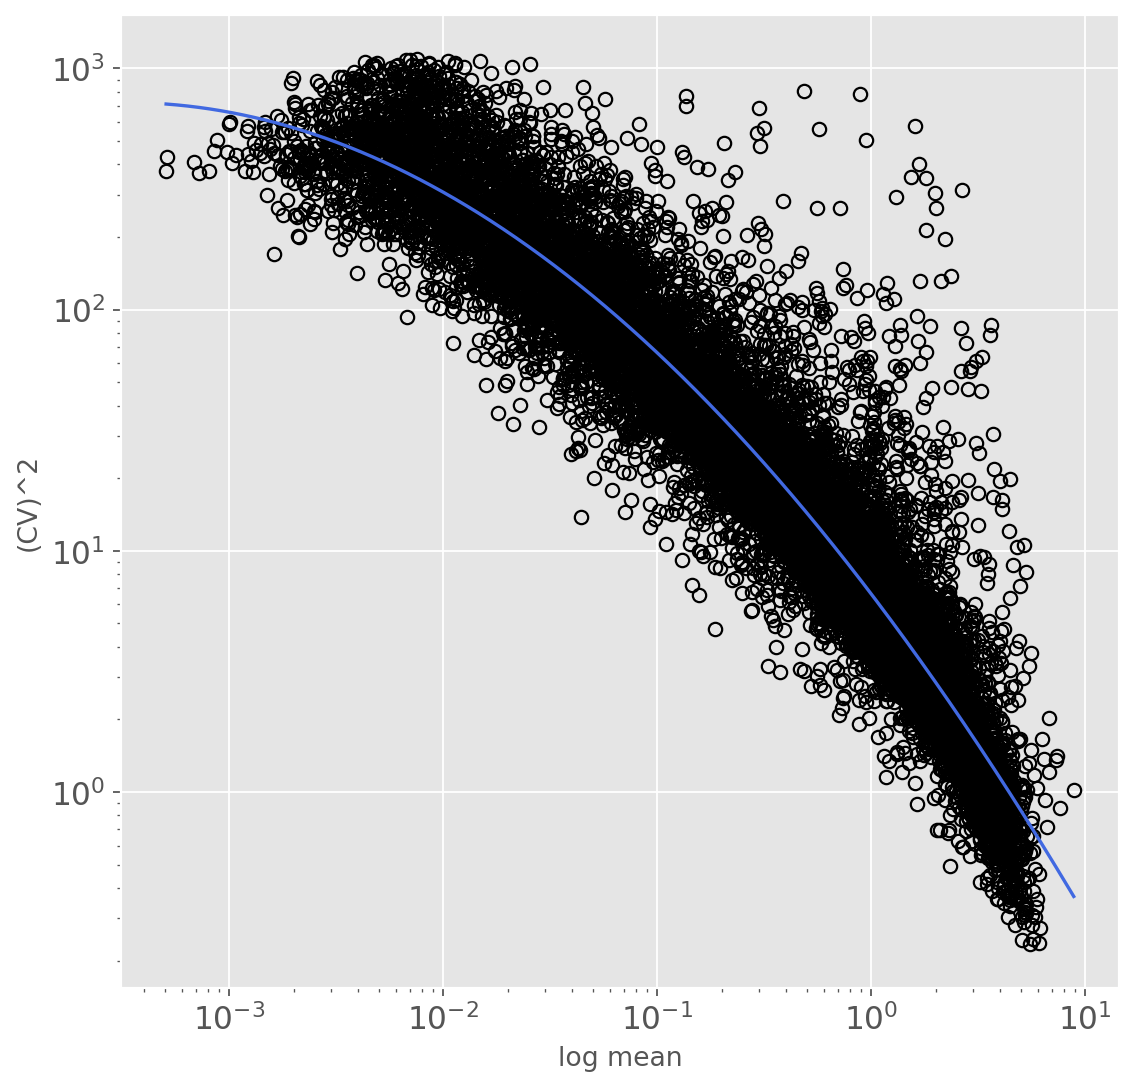

In [10]:
tools.pl.dispersion_plot(adata, "counts")

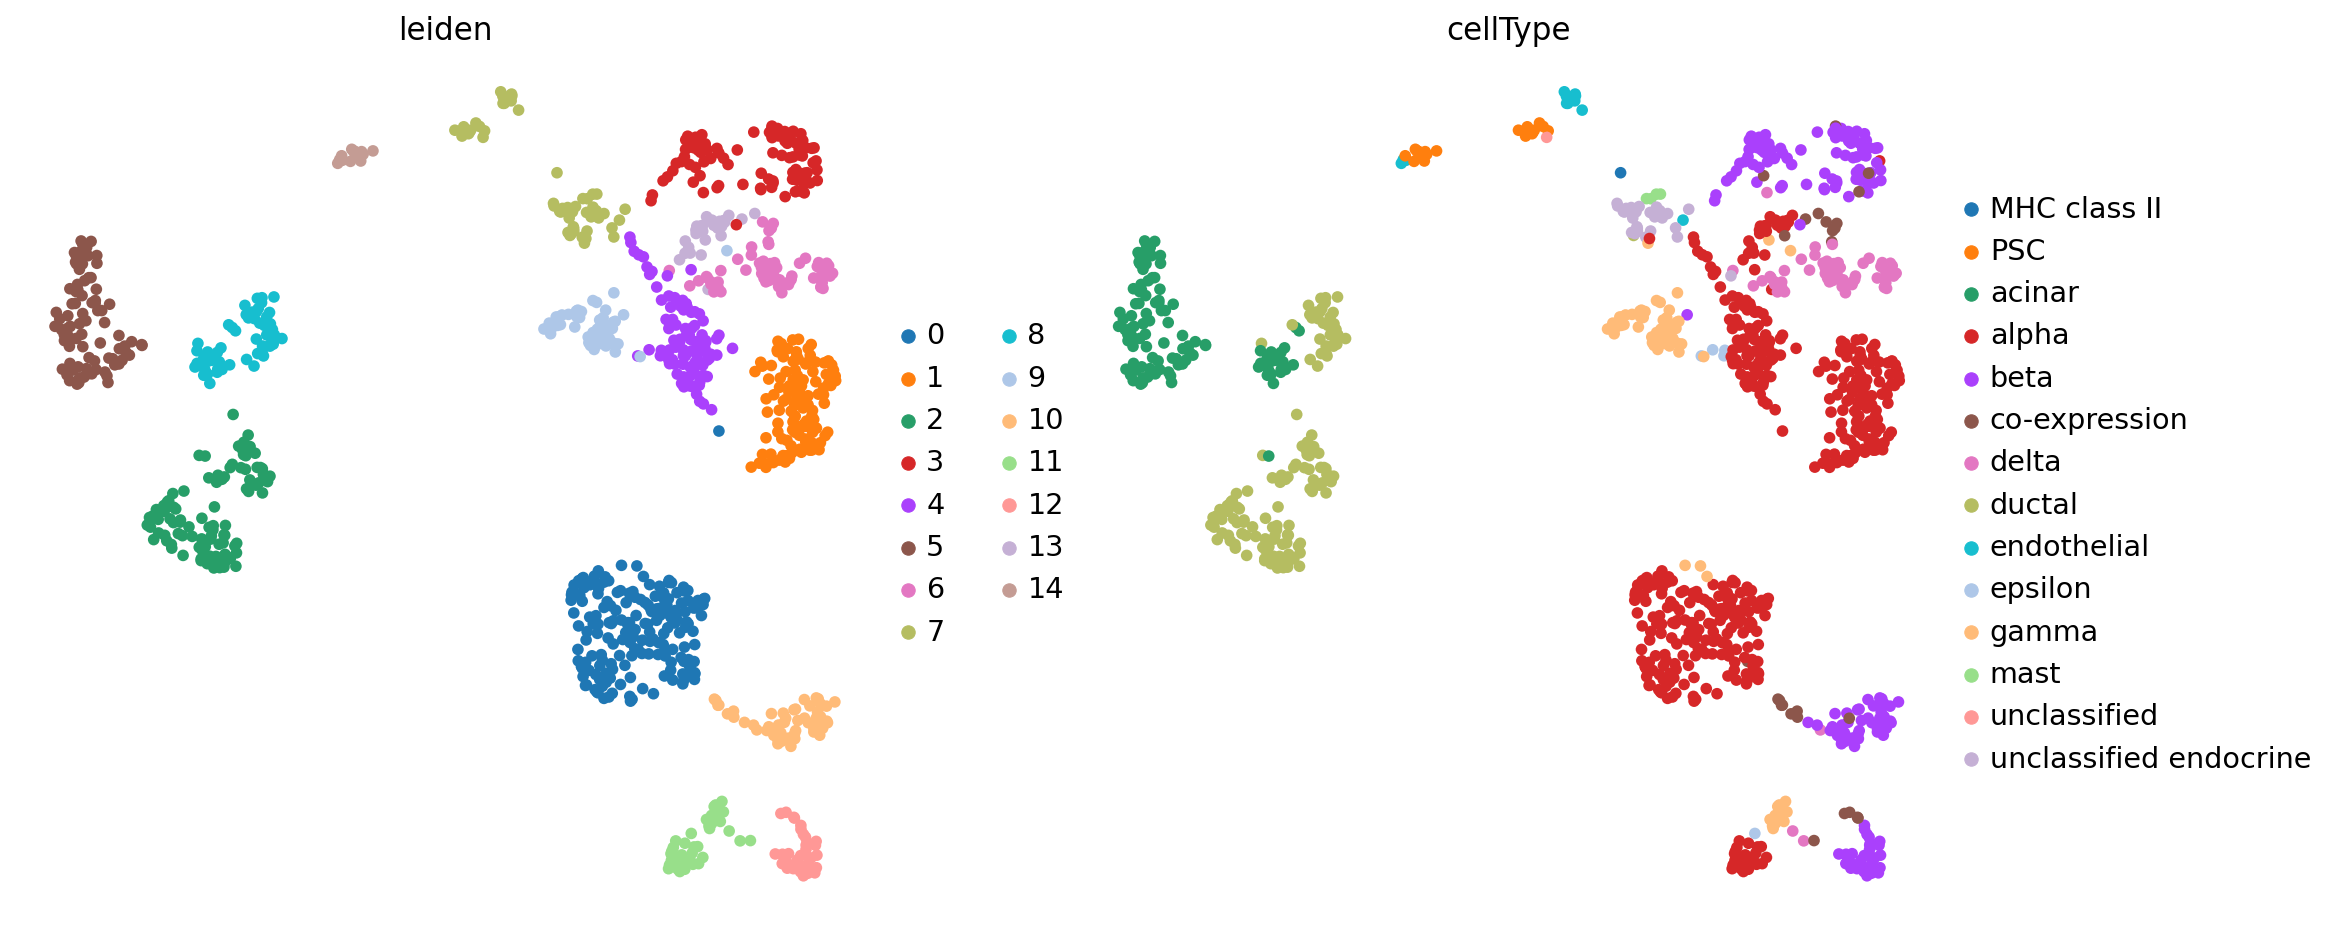

In [11]:
sc.settings.set_figure_params(dpi=80, facecolor='white', figsize=(7,7))
sc.tl.pca(adata)
sc.pp.neighbors(adata, random_state=0)
sc.tl.umap(adata, min_dist=0.5)
sc.tl.leiden(adata, random_state=0, resolution=0.5)
sc.pl.umap(adata,  color=["leiden", "cellType"], ncols=2, frameon=False)

In [12]:
adata = adata[:, ((adata.layers["counts"] != 0).mean(0) > 0.9)].copy()


In [13]:
bulk_adata = bulk_adata[:, bulk_adata.var.index.isin(adata.var.index)].copy()

In [14]:
cell_types = list(adata.obs.groupby("cellType").size().index[adata.obs.groupby("cellType").size() > 1])
cell_types = ["alpha", "beta", "gamma", "delta", "acinar", "ductal"]

In [15]:
adata = adata[adata.obs["cellType"].isin(cell_types)].copy()

In [16]:
adata.obs.groupby("cellType").size()

cellType
acinar    112
alpha     443
beta      171
delta      59
ductal    135
gamma      75
dtype: int64

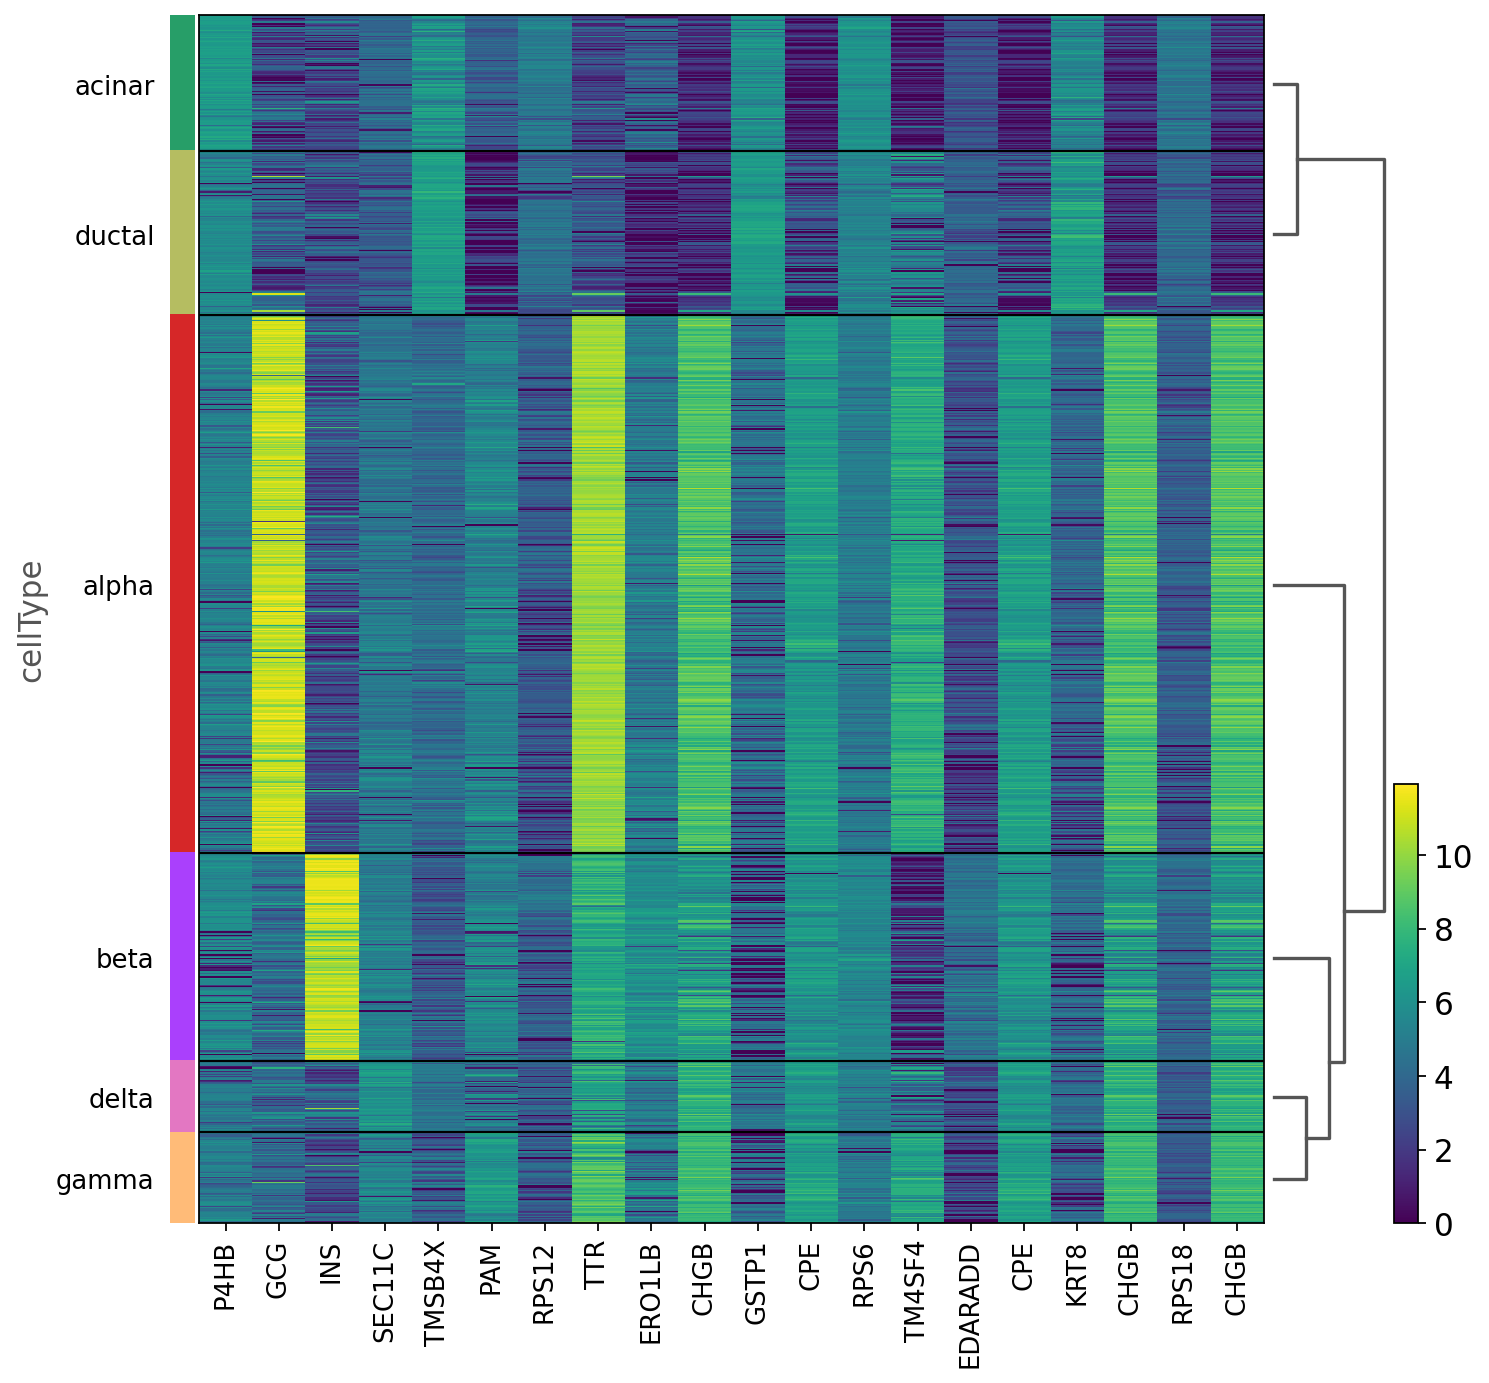

In [17]:
sc.tl.rank_genes_groups(adata, "cellType", method="t-test")
marker_genes = list(sum(adata.uns["rank_genes_groups"]["names"][:100].tolist(),()))
sc.pl.heatmap(adata, marker_genes[:20], groupby="cellType", cmap="viridis", dendrogram=True, figsize=(10,10))

In [18]:
def create_dataset(adata, bulk_adata, genes=None, layer="counts", label_key="leiden", res_limits=(0.001, 1000)):
    if genes is None:
        _adata = adata.copy()
        _bulk_adata = bulk_adata.copy()
    else:
        _adata = adata[:,adata.var.index.isin(genes)].copy()
        _bulk_adata = bulk_adata[:,bulk_adata.var.index.isin(genes)].copy()

    X = []

    pseudo = torch.tensor(_adata.layers[layer].sum(0))
    pseudo /= pseudo.sum()

    for i, cell_type in enumerate(_adata.obs[label_key].cat.categories):
        _x = _adata[_adata.obs[label_key] == cell_type].layers[layer]
        X.append(torch.tensor(_x))

    Y = torch.tensor(_bulk_adata.layers[layer]).squeeze()

    return X, Y, pseudo

In [19]:
adata.layers["ncounts"] = sc.pp.normalize_total(adata, inplace=False, layer="counts")["X"]
bulk_adata.layers["ncounts"] = sc.pp.normalize_total(bulk_adata, inplace=False, layer="counts")["X"]

In [20]:
X, Y, pseudo = create_dataset(adata, bulk_adata, genes=None, label_key="cellType", res_limits=None, layer="ncounts")

In [23]:
Y.dim()

2

In [70]:
n_cell_types = len(adata.obs["cellType"].cat.categories)
n_genes = Y.shape[-1]

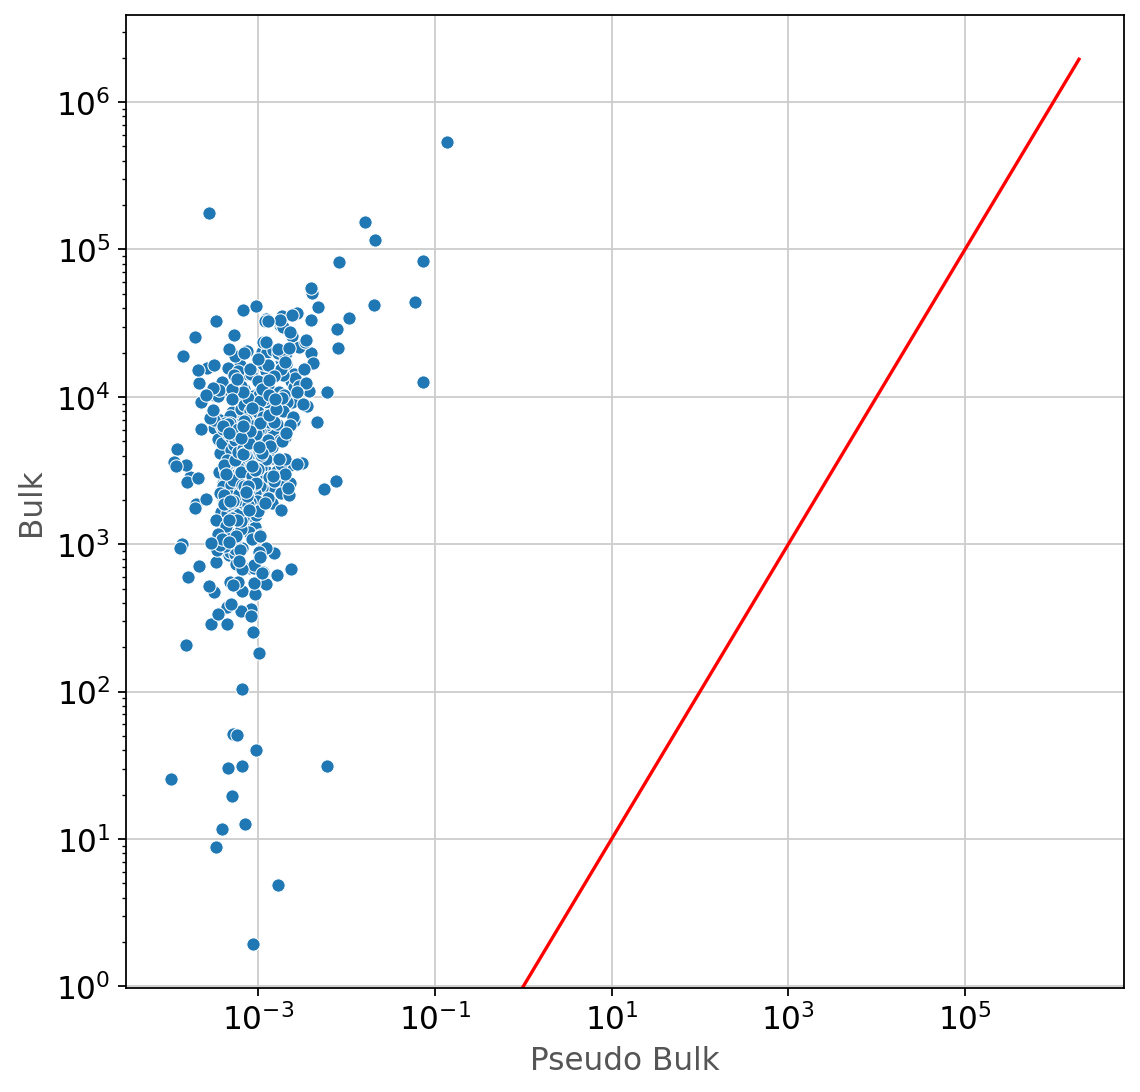

In [71]:
f, ax = plt.subplots(1, 1, figsize=(8,8))
sns.scatterplot(x=pseudo, y=Y[2,:], ax = ax)
ax.plot([0,Y.max()], [0,Y.max()], label="y=x", c="red")
# ax.set_xlim(0, 2000)
# ax.set_ylim(0, 2000)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Pseudo Bulk")
ax.set_ylabel("Bulk")
plt.savefig("Bulk_pseudo.png")
plt.show()

In [72]:
loc = torch.empty(n_genes, n_cell_types)
scale = torch.empty(n_genes, n_cell_types)

for cell_type in range(n_cell_types):
    loader = torch.utils.data.DataLoader(X[cell_type], batch_size=32)

    loc[:,cell_type] = X[cell_type].mean(0)
    scale[:,cell_type]  = X[cell_type].std(0)

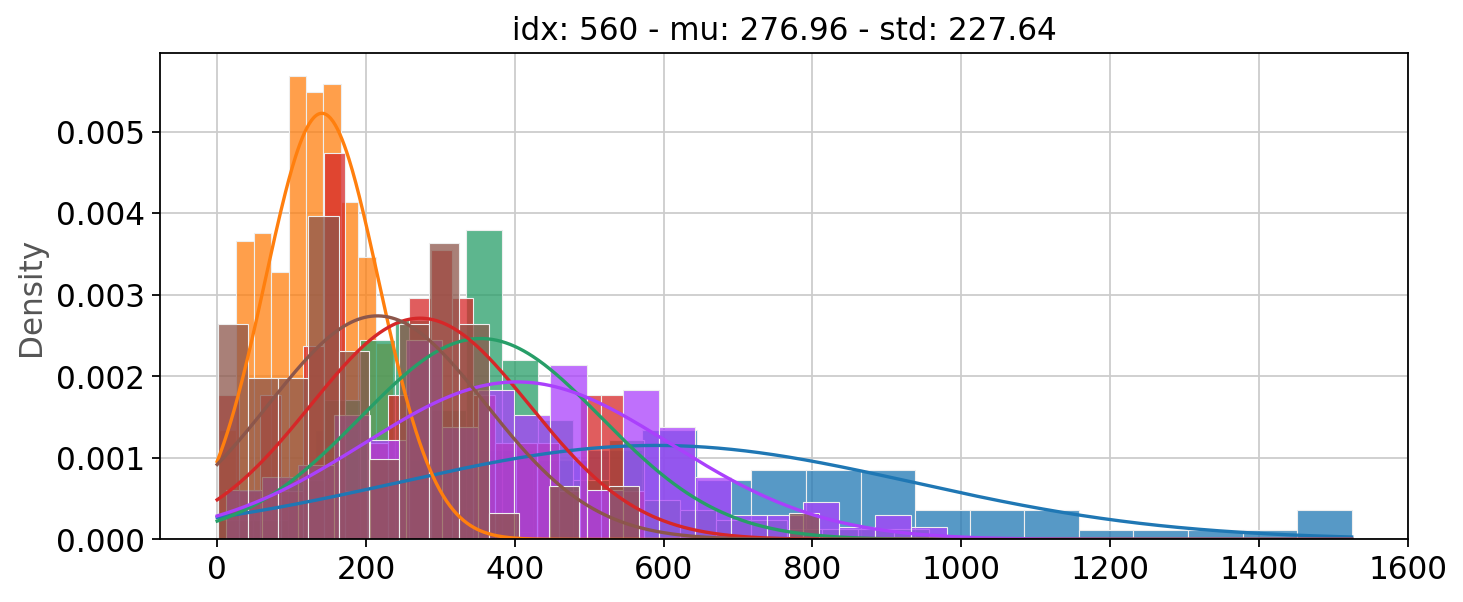

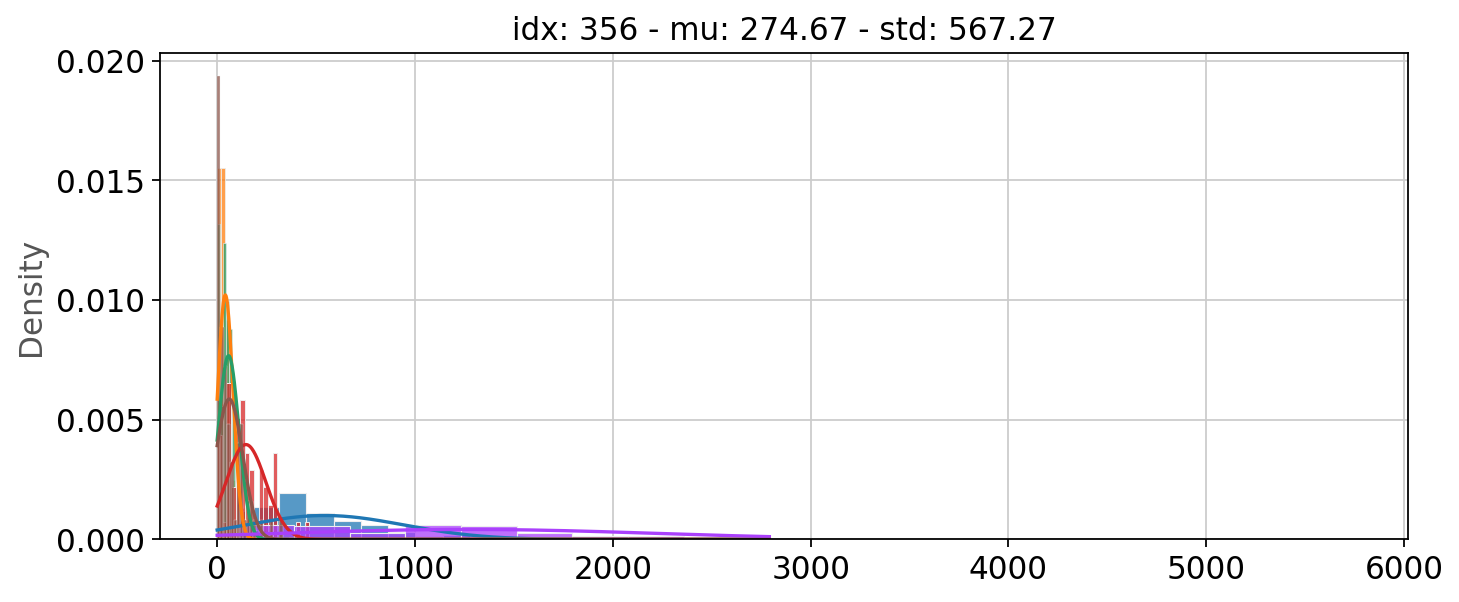

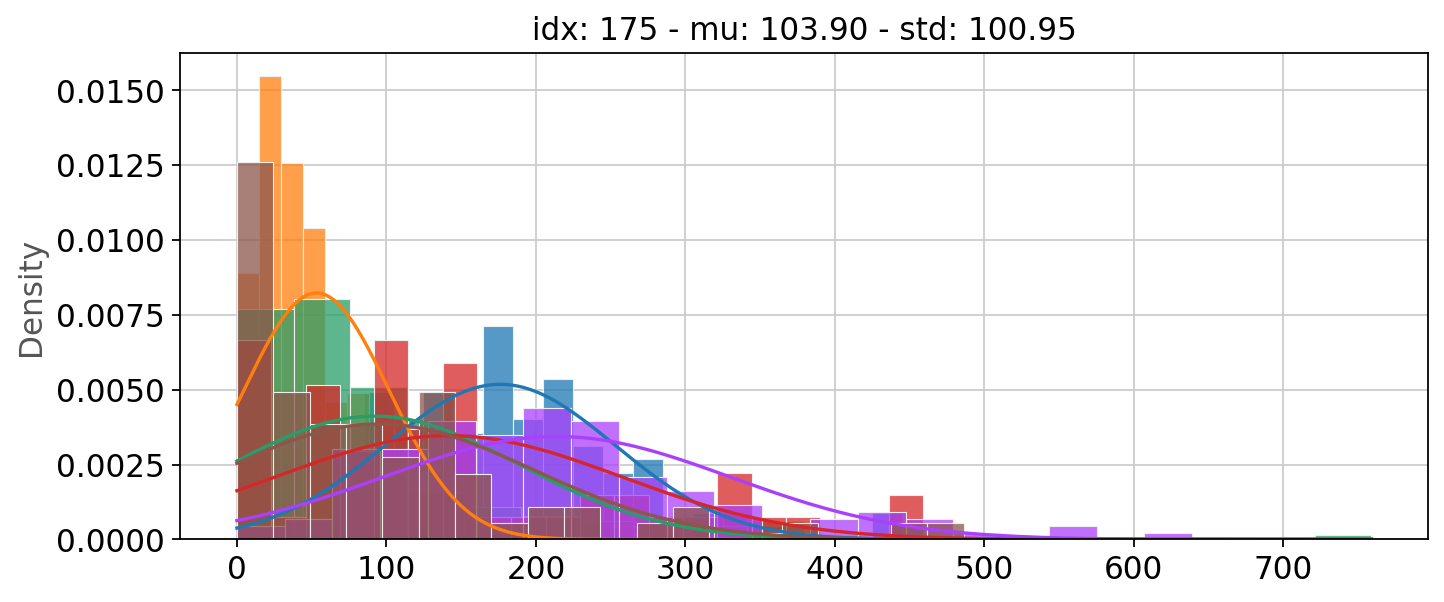

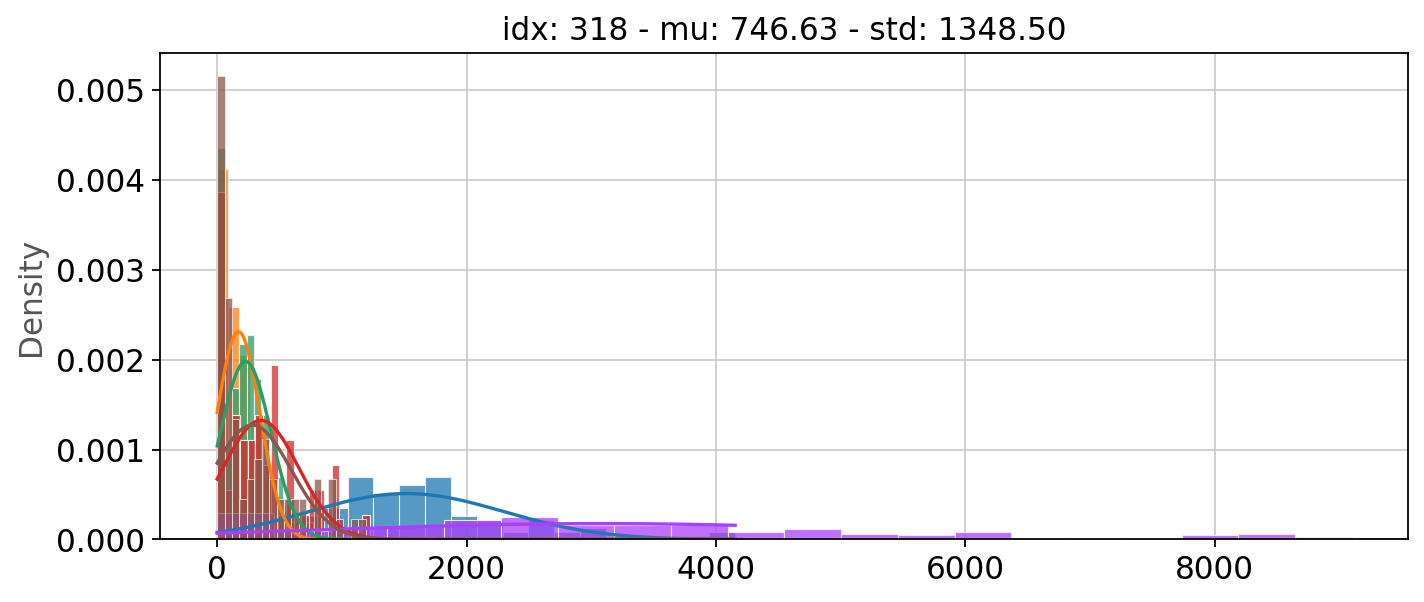

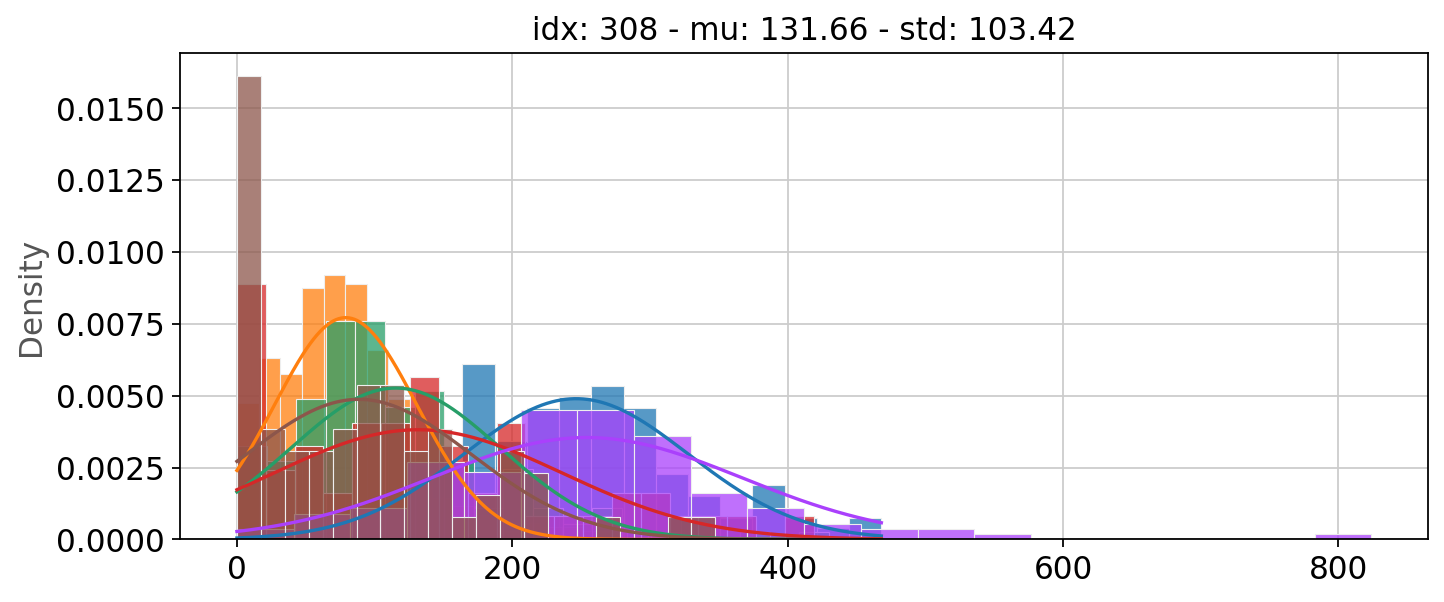

In [92]:
for i in range(5):
    gene = list(adata.var.index).index(marker_genes[np.random.permutation(len(marker_genes))[i]])
    f, ax = plt.subplots(1, 1, figsize=(10,4))
    for cell_type in range(n_cell_types):
        sns.histplot(X[cell_type][:,gene], bins=20, stat="density", ax=ax, color=sns.color_palette()[cell_type])
        # plt.hist(X[cell_type][:,gene], bins=20, density=True, alpha=0.5, color=sns.color_palette()[cell_type])
        xx = torch.linspace(0, max(X[0][:,gene].max(), X[1][:,gene].max(), X[2][:,gene].max()), 1000)
        d = D.Normal(loc[gene, cell_type], torch.max(torch.tensor(0.000001), scale[gene, cell_type]))
        sns.lineplot(x=xx, y=d.log_prob(xx).exp().detach(), ax=ax, color=sns.color_palette()[cell_type])
        c = torch.concat(X)[:,gene]
        ax.set_title(f"idx: {gene} - mu: {c.mean().item():.2f} - std: {c.std().item():.2f}")
    plt.savefig("fit.pdf")
    plt.show()

In [93]:
def fmt_c(w):
    return " ".join([f"{v:.2f}" for v in D.Categorical(torch.abs(w)).probs])

In [94]:
pbar = tqdm.tqdm(range(10000), position=0, leave=True)
model = NSM(loc, scale)
optim = torch.optim.Adam(model.parameters(), lr=0.01)

for i in pbar:
    optim.zero_grad()
    loss = model(Y[88])
    loss.backward()
    optim.step()
    # if i % 50 == 0:
    pbar.set_postfix({"loss":f"{loss.item():.1f}", "props" : fmt_c(model.weights.data), "lib_size": f"{model.lib_size.data.exp():.1f}"})

pbar.set_postfix({"loss":f"{loss.item():.1f}", "props" : fmt_c(model.weights.data), "lib_size": f"{model.lib_size.data.exp():.1f}"})

100%|██████████| 10000/10000 [00:08<00:00, 1189.71it/s, loss=126.7, props=0.06 0.01 0.00 0.00 0.00 0.93, lib_size=131.2]


In [95]:
adata.obs["cellType"].cat.categories

Index(['acinar', 'alpha', 'beta', 'delta', 'ductal', 'gamma'], dtype='object')